### Imports

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### Data

In [ ]:
file_path = 'SpotifyFeatures.csv'
data = pd.read_csv(file_path)
data.head()

### Data preprocessing

In [35]:
# Handle outliers in the dataset
# remove song that are to long in duration songs longer than 500000 ms (500 seconds = 8.3 minutes)

data.head()
data = data[data['duration_ms'] < 500000]
data = data[data["loudness"] > -30]

data['genre_count'] = data.groupby('track_id')['genre'].transform('count')

# drop gernre a capella
data = data[data['genre'] != 'A Capella']

# Combine union child genres
data['genre'] = data['genre'].replace('Children’s Music', 'Children\'s Music')


#SPEECH PER GENRE



In [36]:
# Function to convert pitch to number
def pitch_to_number(pitch):
    pitch_map = {
        'C': 0,
        'C#': 1, 'Db': 1,
        'D': 2,
        'D#': 3, 'Eb': 3,
        'E': 4, 'Fb': 4,
        'E#': 5, 'F': 5,
        'F#': 6, 'Gb': 6,
        'G': 7,
        'G#': 8, 'Ab': 8,
        'A': 9,
        'A#': 10, 'Bb': 10,
        'B': 11, 'Cb': 11
    }
    return pitch_map.get(pitch, None)

# Replace the pitch column with its numeric representation
# Assuming the column name in your DataFrame that contains pitch values is 'pitch_column'
data['key'] = data['key'].apply(pitch_to_number)


In [37]:
data['time_signature'] = data['time_signature'].apply(lambda x: x.split('/')[0])

In [38]:
# Convert the mode column to 1 for major and 0 for minor
data['mode'] = data['mode'].replace("Minor", 0)
data['mode'] = data['mode'].replace("Major", 1)

data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre_count
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,1,0.3460,-1.828,1,0.0525,166.969,4,0.814,1
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,6,0.1510,-5.559,0,0.0868,174.003,4,0.816,1
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,0,0.1030,-13.879,0,0.0362,99.488,5,0.368,1
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,1,0.0985,-12.178,1,0.0395,171.758,4,0.227,1
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,5,0.2020,-21.150,1,0.0456,140.576,4,0.390,1


In [39]:
# group by genre
grouped = data.groupby('genre')
#print(grouped.size())

# Group by genre and calculate mean popularity
grouped = data.groupby('genre')
mean_popularity = grouped['popularity'].mean()

# Function to label rows as 'bop' or 'flop'
def label_popularity(row, mean_popularity):
    if row['popularity'] >= mean_popularity[row['genre']]:
        return 'bop'
    else:
        return 'flop'

# Apply the function to each row
data['popularity_label'] = data.apply(lambda row: label_popularity(row, mean_popularity), axis=1)

# Splitting the data into bop and flop, ensuring each genre is split 50/50
# This step might require adjusting the labels for genres with an odd number of entries
for genre in data['genre'].unique():
    genre_data = data[data['genre'] == genre]
    n = len(genre_data) // 2
    popular_indices = genre_data.nlargest(n, 'popularity').index
    nonpopular_indices = genre_data.nsmallest(n, 'popularity').index
    data.loc[popular_indices, 'popularity_label'] = 'bop'
    data.loc[nonpopular_indices, 'popularity_label'] = 'flop'

data.head()  # Display the first few rows of the modified DataFrame





,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre_count,popularity_label
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,1,0.3460,-1.828,1,0.0525,166.969,4,0.814,1,flop
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,6,0.1510,-5.559,0,0.0868,174.003,4,0.816,1,flop
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,0,0.1030,-13.879,0,0.0362,99.488,5,0.368,1,flop
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,1,0.0985,-12.178,1,0.0395,171.758,4,0.227,1,flop
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,5,0.2020,-21.150,1,0.0456,140.576,4,0.390,1,flop


In [ ]:
# Calculate and print the size difference between nonpopular and popular for each genre
size_difference = data.groupby(['genre', 'popularity_label']).size().unstack().fillna(0)
size_difference['difference'] = size_difference['popular'] - size_difference['nonpopular']
size_difference


popularity_label,nonpopular,popular,difference
genre,,,
A Capella,62,57,-5
Alternative,4783,4452,-331
Anime,4552,4280,-272
Blues,4487,4280,-207
Children's Music,2959,2426,-533
Children’s Music,4794,4528,-266
Classical,3484,3484,0
Comedy,4689,4452,-237
Country,4358,4293,-65


<AxesSubplot: xlabel='genre'>

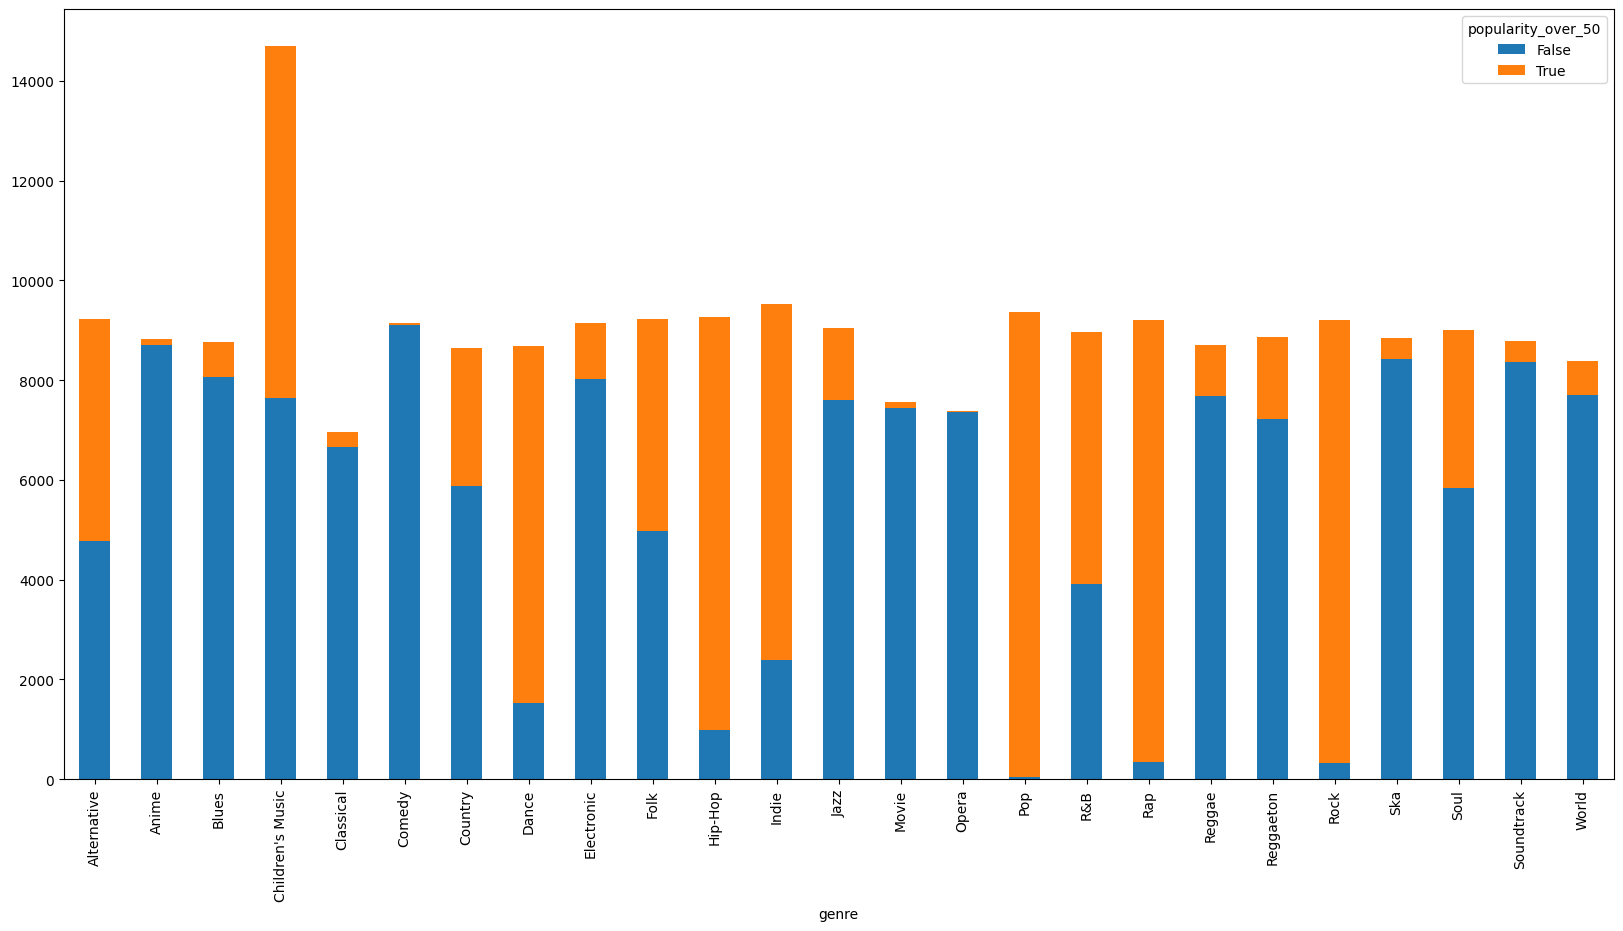

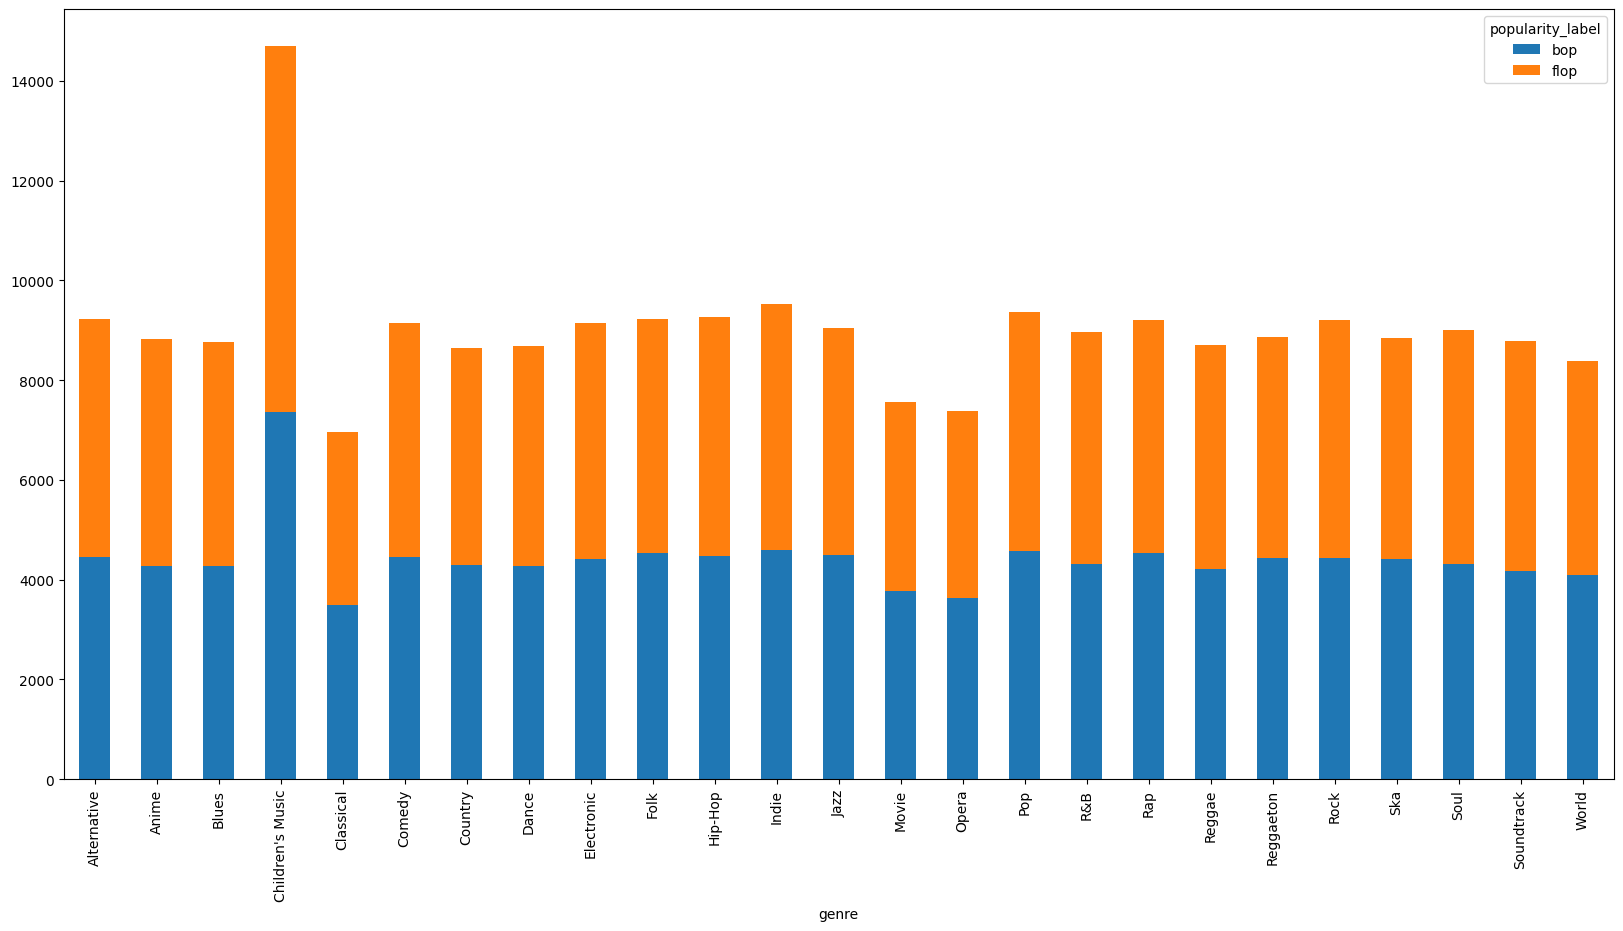

In [40]:
# split data by genre
data['genre'].unique()
data['genre'].value_counts()


# create new column for popularity over 50
data['popularity_over_50'] = data['popularity'] >= 50
data['popularity_over_50'].value_counts()

# create table graph for every genre and popularity over 50


data.groupby(['genre', 'popularity_over_50']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 10))

# make one but with nonpopular and popular
data.groupby(['genre', 'popularity_label']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 10))



In [41]:
# Calculate and print the splitting point (mean popularity) for every genre
splitting_points = mean_popularity.to_dict()
splitting_points


{'Alternative': 50.21418516513265,
 'Anime': 24.29393115942029,
 'Blues': 34.8013003307859,
 "Children's Music": 36.20888012511049,
 'Classical': 29.31113662456946,
 'Comedy': 21.24428399518652,
 'Country': 46.097907756328745,
 'Dance': 57.27614773904039,
 'Electronic': 38.05049180327869,
 'Folk': 49.95996962464743,
 'Hip-Hop': 58.422873773849304,
 'Indie': 54.706981627296585,
 'Jazz': 40.846340924165375,
 'Movie': 12.293814432989691,
 'Opera': 13.39590397395904,
 'Pop': 66.59140358361775,
 'R&B': 52.318956870611835,
 'Rap': 60.5366250678242,
 'Reggae': 35.60999425617461,
 'Reggaeton': 37.76805869074492,
 'Rock': 59.634496250407565,
 'Ska': 28.61764373658647,
 'Soul': 47.027867214388806,
 'Soundtrack': 33.889255633963124,
 'World': 35.574734581891924}

### Model

In [ ]:

# Create a dictionary of classifiers, one for each genre, random forest classifier
classifiers = {}



# Create a classifier for each genre
for genre in data['genre'].unique():
    # Create a new DataFrame containing only the current genre
    genre_data = data[data['genre'] == genre]

    random_seed = 1337
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(genre_data[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'genre_count']], genre_data['popularity_label'], test_size=0.2, random_state=random_seed)


    
    # add more to votingClassifier
    classifier = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=50, random_state=random_seed)),
        ('gb', GradientBoostingClassifier(n_estimators=50, random_state=random_seed)),
        ('ab', AdaBoostClassifier(n_estimators=50, random_state=random_seed)),
        ('lr', LogisticRegression(random_state=random_seed)),
        ('svc', SVC(random_state=random_seed))  # Note: SVC doesn't have a random_state parameter in older versions
    ], 
    voting='hard'
    )

    # Train the classifier
    classifier.fit(X_train, y_train)
    # Add the classifier to the dictionary of classifiers
    classifiers[genre] = classifier

    # add accuracy score to dictionary
    classifiers[genre] = classifier.score(X_test, y_test)
    print("genre: ", genre, " Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
    print("genre: ", genre, " Accuracy score (validation): {0:.3f}".format(classifier.score(X_test, y_test)))

    

# Print the dictionary of classifiers
classifiers

genre:  Movie  Accuracy score (training): 0.791
genre:  Movie  Accuracy score (validation): 0.647
genre:  R&B  Accuracy score (training): 0.851
genre:  R&B  Accuracy score (validation): 0.768
genre:  Alternative  Accuracy score (training): 0.814
genre:  Alternative  Accuracy score (validation): 0.667
genre:  Country  Accuracy score (training): 0.726
genre:  Country  Accuracy score (validation): 0.696
genre:  Dance  Accuracy score (training): 0.735
genre:  Dance  Accuracy score (validation): 0.660
genre:  Electronic  Accuracy score (training): 0.725
genre:  Electronic  Accuracy score (validation): 0.637
genre:  Anime  Accuracy score (training): 0.704
genre:  Anime  Accuracy score (validation): 0.626
genre:  Folk  Accuracy score (training): 0.790
genre:  Folk  Accuracy score (validation): 0.765
genre:  Blues  Accuracy score (training): 0.724
genre:  Blues  Accuracy score (validation): 0.656
genre:  Opera  Accuracy score (training): 0.721
genre:  Opera  Accuracy score (validation): 0.564


{'Movie': 0.6466314398943197,
 'R&B': 0.7676880222841226,
 'Alternative': 0.6670276123443422,
 'Country': 0.6955517042172155,
 'Dance': 0.660149511213341,
 'Electronic': 0.6366120218579235,
 'Anime': 0.6264855687606112,
 'Folk': 0.764642082429501,
 'Blues': 0.6562143671607754,
 'Opera': 0.5640677966101695,
 'Hip-Hop': 0.6939655172413793,
 "Children's Music": 0.6658735554044868,
 'Rap': 0.6673901247965274,
 'Indie': 0.6729658792650919,
 'Classical': 0.6226685796269728,
 'Pop': 0.5383795309168443,
 'Reggae': 0.569213095921884,
 'Reggaeton': 0.5908577878103838,
 'Jazz': 0.6607734806629835,
 'Rock': 0.5355784899511136,
 'Ska': 0.5736871823828346,
 'Comedy': 0.6183706943685073,
 'Soul': 0.7081021087680355,
 'Soundtrack': 0.555745164960182,
 'World': 0.6129994036970781}

In [ ]:
# print avg accuracy score
avg = 0
for genre in classifiers:
    avg += classifiers[genre]
avg /= len(classifiers)
print(avg)


0.638865628901865


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


plot_scores = []

for n_estimator in range(1, 501, 50):
    classifiers = {}
    avg_score = 0

    for genre in data['genre'].unique():
        genre_data = data[data['genre'] == genre]
        random_seed = 1337
        X_train, X_test, y_train, y_test = train_test_split(
            genre_data[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'genre_count']], 
            genre_data['popularity_label'], 
            test_size=0.2, 
            random_state=random_seed
        )

        classifier = VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=n_estimator, random_state=random_seed)),
                ('gb', GradientBoostingClassifier(n_estimators=n_estimator, random_state=random_seed)),
                ('ab', AdaBoostClassifier(n_estimators=n_estimator, random_state=random_seed)),
                ('lr', LogisticRegression(random_state=random_seed)),
                ('svc', SVC(random_state=random_seed))
            ], 
            voting='hard'
        )

        classifier.fit(X_train, y_train)
        score = classifier.score(X_test, y_test)
        classifiers[genre] = score
        avg_score += score

    avg_score /= len(data['genre'].unique())
    plot_scores.append(avg_score)

plt.plot(range(1, 501, 50), plot_scores)
plt.ylabel('Average Accuracy Score')
plt.xlabel('Number of Estimators')
plt.show()